In [1]:
import cnfg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine
%matplotlib inline
sns.set_style("whitegrid")

params = {'axes.labelsize': 14,
          'axes.labelweight': 'bold',
          'axes.titlesize': 16,
          'figure.titleweight': 'bold'}
plt.rcParams.update(params)

# Redshift Setup

I copied all of the CSV files to S3, then to a Redshift cluster to quickly query the data.<br/>
All of the transactions are stored in table `mortgage_transactions`. 

I also created 2 views:
 - `mortgage_lender`: Stores loan count and amounts made by year and lender
 - `lendinghome_competitor_2014`: Stores a list of lenders that had similar transaction volumes as LendingHome in 2014

See `mortgage_transactions.sql` for the table and view schemas. 

In [2]:
config = cnfg.load(".metis_config")['redshift']
engine = create_engine('postgresql://{}:{}@{}:5439/{}'.format(
                        config['user'],
                        config['pwd'],
                        config['host'],
                        'master'))

# Mortgage Market

My analysis assumes that the most important factor in profitability is the total amount of loans distributed. Therefore any transactions where loan_amount = 0 are ignored.

In 2016:
- Around 26K distinct lenders
- The mean of the total amount of loans distributed by a lender = \$90 million, with standard deviation = \$3.9 billion.
- The mean of total loan count made by a lender = 56, with standard deviation = 834. <br/>

The huge variance in annual loan amount and count suggests that the majority of lenders are small but there are a few lenders with huge volume that dominate the mortgage market.

total_loan_amount                                                         \
                 count          mean           std    min       25%       50%   
year                                                                            
2014           32237.0  1.035123e+08  7.063215e+09   10.0  109000.0  295000.0   
2015           28538.0  9.127634e+07  6.738039e+09   26.0  110000.0  295000.0   
2016           26022.0  9.076891e+07  3.869077e+09  100.0  120000.0  300000.0   
2017           18937.0  7.706467e+07  5.588536e+09  904.0  130000.0  320000.0   

                             total_loan_count                              \
           75%           max            count       mean         std  min   
year                                                                        
2014  813000.0  8.292334e+11          32237.0  32.674753  540.895070  1.0   
2015  761992.0  1.090213e+12          28538.0  47.245707  739.400828  1.0   
2016  800000.0  4.148815e+11          26022.0  56.403313  834.099455  1.0   
2017  900000.0  7.564708e+11          18937.0  36.704758  449.306642  1.0   

                              
      25%  50%  75%      max  
year                          
2014  1.0  1.0  2.0  57012.0  
2015  1.0  1.0  2.0  47365.0  
2016  1.0  1.0  2.0  56407.0  
2017  1.0  1.0  2.0  24324.0

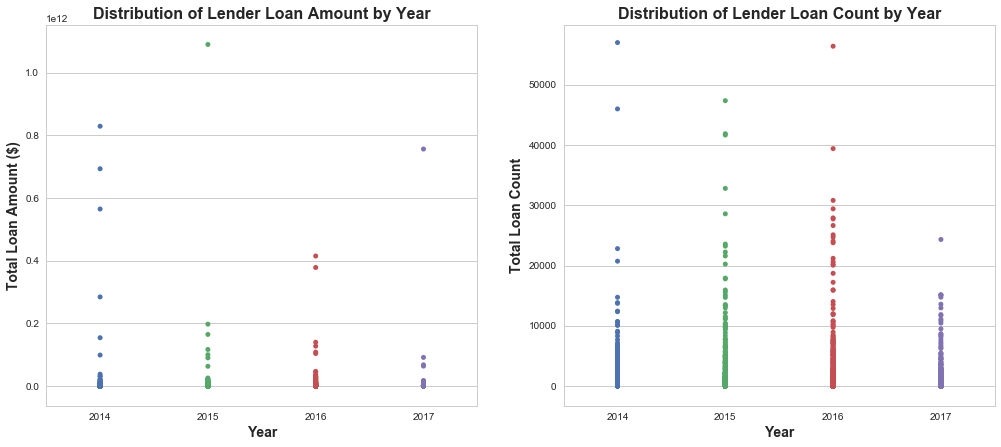

In [3]:
def summarize_lender_transactions():    
    query = """
    SELECT
      year, total_loan_count, total_loan_amount
    FROM mortgage_lender
    WHERE year >= 2014
    """
    df_annual_lender_loans = pd.read_sql_query(query, engine)
    
    fig, ax = plt.subplots(1, 2, figsize=(17, 7))
    
    p1 = sns.stripplot(x="year", y="total_loan_amount", data=df_annual_lender_loans, ax=ax[0]);
    p1.set_xlabel('Year')
    p1.set_ylabel('Total Loan Amount ($)')
    p1.set_title('Distribution of Lender Loan Amount by Year', fontweight='bold')
    
    p2 = sns.stripplot(x="year", y="total_loan_count", data=df_annual_lender_loans, ax=ax[1]);
    p2.set_xlabel('Year')
    p2.set_ylabel('Total Loan Count')
    p2.set_title('Distribution of Lender Loan Count by Year', fontweight='bold')
    return df_annual_lender_loans

df_annual_lender = summarize_lender_transactions()
df_annual_lender.groupby('year').describe()

# LendingHome Analysis

After 2014, the annual LendingHome loan count has been relatively consistent: between 450-550 loans a year. <br/>
The total loan amount stayed relatively consistent between 2015 and 2016, but has drastically increased in 2017.

,total_loan_count,total_loan_amount,total_loan_amount_formatted
year,,,
2014,153,41114800,4.11E+07
2015,527,167054800,1.67E+08
2016,467,164213002,1.64E+08
2017,519,196419732,1.96E+08


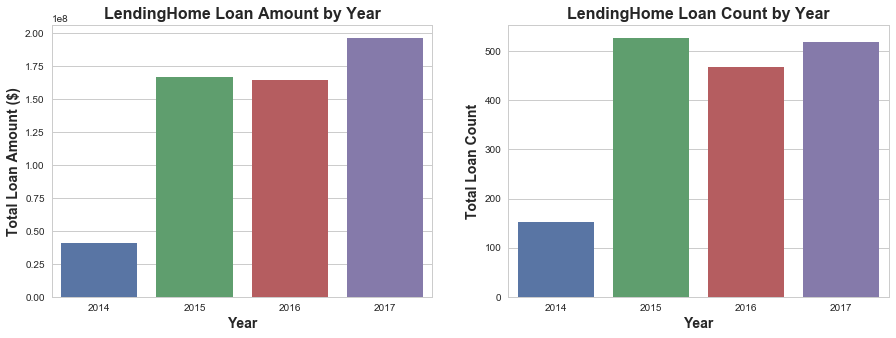

In [47]:
def get_lh_annual_loan_data():
    query = """
    SELECT
      year,
      SUM(total_loan_count) AS total_loan_count,
      SUM(total_loan_amount) AS total_loan_amount
    FROM mortgage_lender
    WHERE
      lender ILIKE '%%lendinghome%%'
    GROUP BY year
    ORDER BY year"""
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    df_loan_data = pd.read_sql_query(query, engine)
    df_loan_data = df_loan_data.set_index('year')
    df_loan_data['total_loan_amount_formatted'] = df_loan_data[
        'total_loan_amount'].map(lambda a: "{:.2E}".format(a))
    
    p1 = sns.barplot(x="year", y="total_loan_amount", data=df_loan_data.reset_index(), ax=ax[0]);
    p1.set_xlabel('Year')
    p1.set_ylabel('Total Loan Amount ($)')
    p1.set_title('LendingHome Loan Amount by Year', fontweight='bold')
    
    p2 = sns.barplot(x="year", y="total_loan_count", data=df_loan_data.reset_index(), ax=ax[1]);
    p2.set_xlabel('Year')
    p2.set_ylabel('Total Loan Count')
    p2.set_title('LendingHome Loan Count by Year', fontweight='bold')
    return df_loan_data
    
lh_annual_loan_data = get_lh_annual_loan_data()
lh_annual_loan_data

### Loan to Transaction Value

LTV(Loan to Value) is defined as the ratio of loan amount / transaction amount. 

For transactions where loan amount > 0, divide loan transactions into 3 categories:
- `Refinance` when transaction amount = 0.  
- `High LTV` when loan amount / transaction amount >=1.  
- `Regular` for all other loans

LendingHome has a higher proportion of High LTV transactions than is common amongst most transactions.<br/>

Compared to the majority of loans, LendingHome has a much lower percentage of loans that are for refinances.

In [5]:
def plot_loan_transaction_ratios(title='All Loans', lender_filter='IS NOT NULL'):
    """Investigate how often loan amount > transaction amount"""
    query_transaction_ratio = """
    SELECT
    loan_amount::float / transaction_amount AS transaction_proportion
    FROM mortgage_transactions
    WHERE
    transaction_amount > 0
    AND loan_amount > 0
    AND lender {}
    """.format(lender_filter)
    
    fig, ax = plt.subplots(1, 1, figsize=(17, 7))
    df_loan_transaction_ratio = pd.read_sql_query(query_transaction_ratio, engine)
    df_loan_transaction_ratio.hist(bins=20, range=(0,2), ax=ax)
    ax.set_ylabel('Loan Count')
    ax.set_xlabel('LTV')
    ax.xaxis.set_ticks(np.arange(0, 2.2, 0.2))
    ax.set_title('LTV Histogram for '+ title, fontweight='bold')

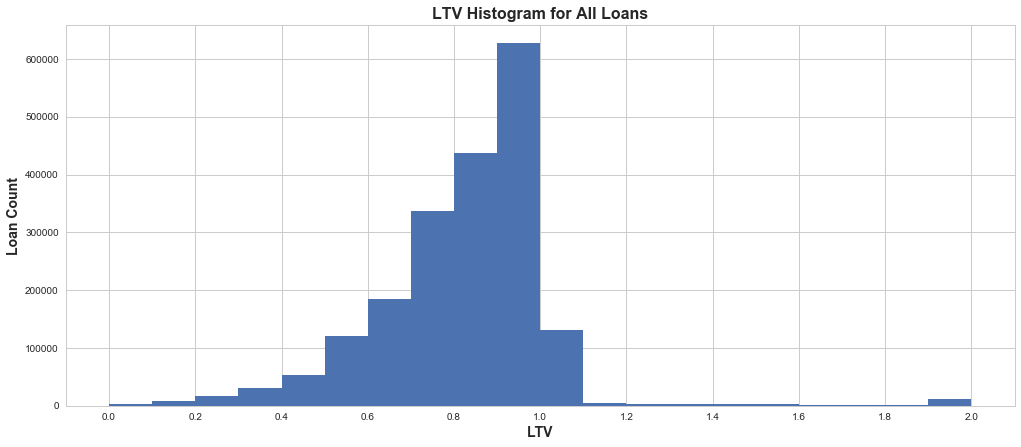

In [6]:
plot_loan_transaction_ratios()

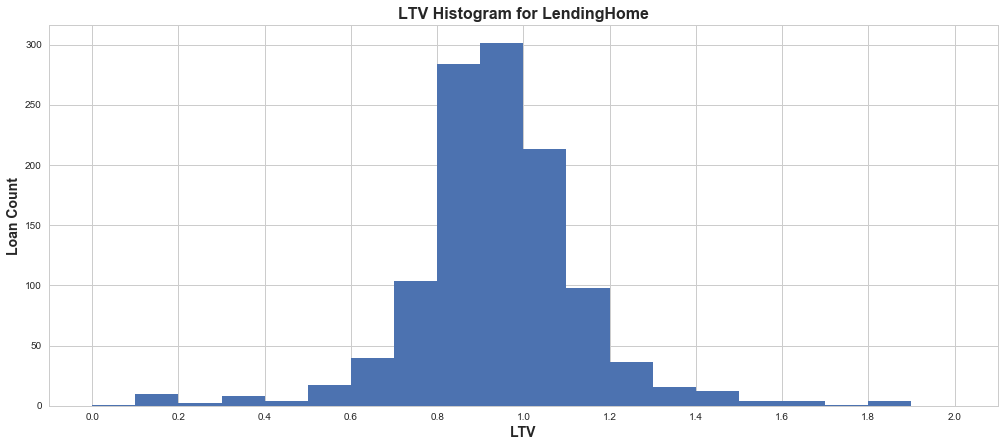

In [7]:
plot_loan_transaction_ratios(title='LendingHome', lender_filter="ILIKE '%%lendinghome%%'")

In [48]:
def plot_loan_type(title, lender_filter='IS NOT NULL'):
    query = """
    SELECT
    EXTRACT('year' from transaction_date) AS year,
      CASE
      WHEN transaction_amount = 0
      THEN 'Refinance'
      WHEN transaction_amount > 0 and loan_amount::FLOAT/transaction_amount > 1
      THEN 'High LTV'
      ELSE 'Regular'
     END AS transaction_type,
     COUNT(1) AS loan_count,
     ratio_to_report(COUNT(1)) OVER (PARTITION BY year) * 100 AS percentage_count
    FROM
     mortgage_transactions
    WHERE loan_amount > 0
    AND lender {}
    GROUP BY 1, 2
    ORDER BY 1, 2
    """.format(lender_filter)
    colors = sns.color_palette("husl", 5)
    fig, ax = plt.subplots(1, 1, figsize=(13, 5))
    ax.set_ylabel('Loan Count')
    ax.set_xlabel('Year')
    ax.set_title('Loan Counts by Loan Type for '+ title, fontweight='bold')
    
    df_loan_type = pd.read_sql_query(query, engine)
    df_loan_type.pivot(index='year', columns='transaction_type', values='loan_count').plot(
        ax=ax, kind='bar', color=colors)
    return df_loan_type

,year,transaction_type,loan_count,percentage_count
0,2014,High LTV,26,16.993464
1,2014,Refinance,69,45.098039
2,2014,Regular,58,37.908497
3,2015,High LTV,106,20.113852
4,2015,Refinance,197,37.381404
5,2015,Regular,224,42.504744
6,2016,High LTV,116,24.839400
7,2016,Refinance,96,20.556745
8,2016,Regular,255,54.603854
9,2017,High LTV,126,24.277457


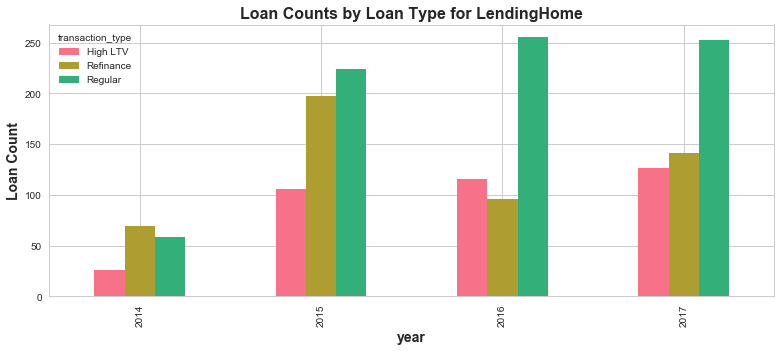

In [49]:
plot_loan_type('LendingHome', lender_filter="ILIKE '%%lendinghome%%'")

,year,transaction_type,loan_count,percentage_count
0,2012,High LTV,25179,1.518182
1,2012,Refinance,1326688,79.993392
2,2012,Regular,306630,18.488427
3,2013,High LTV,23847,1.646443
4,2013,Refinance,1110182,76.649119
5,2013,Regular,314366,21.704438
6,2014,High LTV,24137,2.291403
7,2014,Refinance,719587,68.312714
8,2014,Regular,309648,29.395883
9,2015,High LTV,28451,2.109228


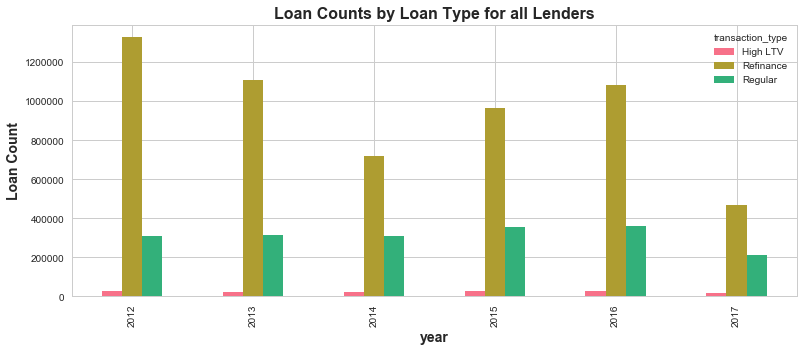

In [50]:
plot_loan_type('all Lenders')

# Competitor Analysis

Given the broad spectrum of lenders, narrow down LendingHome's competitors to lenders that deal with similar annual volume of transactions and loan amount.<br/> 

Define LendingHome's 2014 cohort of competitors as lenders who made between 100 and 200 loans in 2014, with total loan amount summing to between \$30 million and \$50 million. Call this cohort `2014 Competitors`.<br/>

This list of 120 competitor lenders is stored in view `lendinghome_competitor_2014`. 

Track how LendingHome grew in comparison to lenders which were comparable to it in 2014. <br/>

In [8]:
def analyze_competitors(lender_filter='IS NOT NULL'):
    query = """
    SELECT
      year, 
      AVG(total_loan_count) AS total_loan_count, 
      AVG(total_loan_amount) AS total_loan_amount
    FROM (
        SELECT * FROM mortgage_lender
        WHERE
          lender IN (SELECT lender FROM lendinghome_competitor_2014)
        and year >= 2014
    ) competitors
    WHERE lender {}
    GROUP BY year
    ORDER BY year
    """.format(lender_filter)
    df_loan_data = pd.read_sql_query(query, engine)
    df_loan_data['total_loan_amount_formatted'] = df_loan_data[
        'total_loan_amount'].map(lambda a: "{:.2E}".format(a))
    df_loan_data = df_loan_data.set_index('year')
    return df_loan_data
    

Calculate the average of the annual loan count and loan amount distributed by the 2014 cohort of competitors from 2014 to 2017:

In [9]:
competitor_annual_loan_data = analyze_competitors()
competitor_annual_loan_data

,total_loan_count,total_loan_amount,total_loan_amount_formatted
year,,,
2014,135,40586015,4.06E+07
2015,383,122904032,1.23E+08
2016,459,157448040,1.57E+08
2017,220,78031213,7.80E+07


Out of the initial 120 competitors from the 2014 cohort, find the competitors who are doing better than LendingHome in 2017:

In [10]:
def get_2017_competitor_list():
    """Find the 2014 competitors that are doing better than LendingHome in 2017"""
    query = """
    SELECT *
    FROM mortgage_lender
    WHERE
     year = 2017
     AND lender IN (SELECT lender FROM lendinghome_competitor_2014)
     AND total_loan_amount > 196e6
     AND total_loan_count > 519
    """
    df_2017_competitors = pd.read_sql_query(query, engine)
    return df_2017_competitors

get_2017_competitor_list()

,lender,year,total_loan_count,total_loan_amount,median_loan_amount
0,ENVOY MTG LP,2017,660,227114452,324511.0
1,SUPREME LNDG,2017,1461,573218870,368000.0
2,BENCHMARK MTG,2017,611,277705385,424000.0


Define these 3 lenders as a cohort subset called `2017 Better Competitors`.

In [11]:
competitor_2017_annual_loan_data = analyze_competitors(lender_filter="IN ('BENCHMARK MTG', 'ENVOY MTG LP', 'SUPREME LNDG')")
competitor_2017_annual_loan_data

,total_loan_count,total_loan_amount,total_loan_amount_formatted
year,,,
2014,123,40725871,4.07E+07
2015,614,213579975,2.14E+08
2016,1644,632627055,6.33E+08
2017,910,359346235,3.59E+08


Compare LendingHome with these 2 lender cohorts side by side.

In [41]:
def plot_loan_competition():
    lh_annual_loan_data['name'] = 'LendingHome'
    competitor_annual_loan_data['name'] = '2014 Competitors'
    competitor_2017_annual_loan_data['name'] = '2017 Better Competitors'
    lh_and_competitors = pd.concat([lh_annual_loan_data, competitor_annual_loan_data, 
                                    competitor_2017_annual_loan_data]).reset_index()
    fig, ax = plt.subplots(1, 2, figsize=(17, 7))
    colors = sns.color_palette("Paired", 3)
    
    lh_and_competitors.pivot(index='year', columns='name', values='total_loan_count').plot(
        ax=ax[0], kind='bar', color=colors)
    ax[0].set_ylabel('Total Loan Count')
    ax[0].set_xlabel('Year')
    ax[0].set_title('Average Loan Count by Lender Cohort', fontweight='bold')
    ax[0].legend().set_visible(False)
    
    lh_and_competitors.pivot(index='year', columns='name', values='total_loan_amount').plot(
        ax=ax[1], kind='bar', color=colors)
    ax[1].set_ylabel('Total Loan Amount ($)')
    ax[1].set_xlabel('Year')
    ax[1].set_title('Average Loan Amount Total by Lender Cohort', fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=1)
    return lh_and_competitors

The 2 cohorts started off with similar annual loan count and loan amount as LendingHome. <br/>
Between 2015 and 2017, LendingHome has had higher annual loan count & amount than the average lender in the `2014 Competitors` cohort.<br/>

LendingHome growth stagnated between 2015 and 2016, with total loan amount staying at around $160 million. However  there has been significant growth in 2017 of at least 19% in total loan amount (since 2017 data is not complete).

The `2017 Better Competitors` cohort subset has so far outperformed LendingHome in 2017 by 82% in total loan amount.

,year,total_loan_count,total_loan_amount,total_loan_amount_formatted,name
0,2014,153,41114800,4.11E+07,LendingHome
1,2015,527,167054800,1.67E+08,LendingHome
2,2016,467,164213002,1.64E+08,LendingHome
3,2017,519,196419732,1.96E+08,LendingHome
4,2014,135,40586015,4.06E+07,2014 Competitors
5,2015,383,122904032,1.23E+08,2014 Competitors
6,2016,459,157448040,1.57E+08,2014 Competitors
7,2017,220,78031213,7.80E+07,2014 Competitors
8,2014,123,40725871,4.07E+07,2017 Better Competitors
9,2015,614,213579975,2.14E+08,2017 Better Competitors


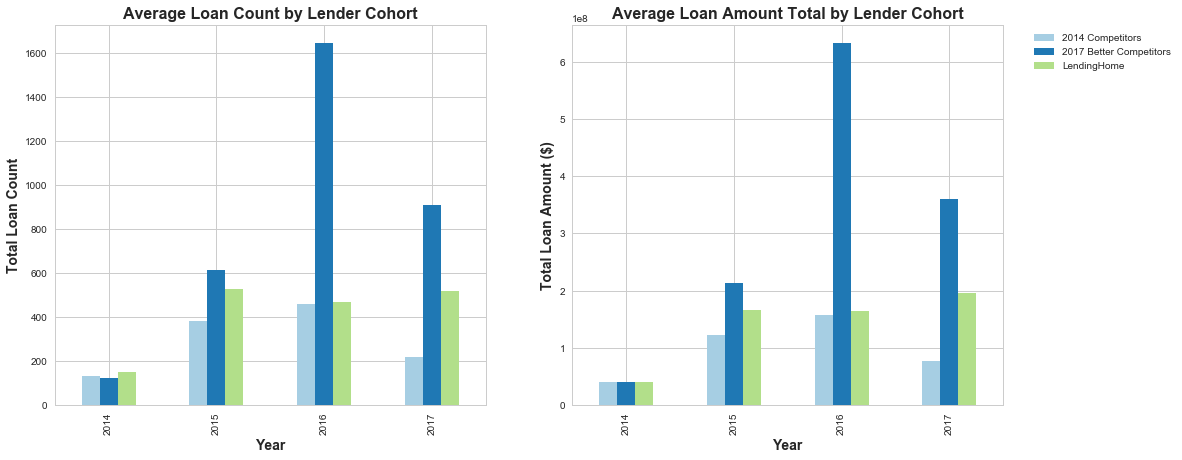

In [42]:
plot_loan_competition()

# Loan Size Analysis

Bucket each loan into 4 sizes:
 - \$ 0-250K (small)
 - \$ 250K-500K (medium)
 - \$ 500K-750K (large)
 - \$ 750K+ (x-large)

In 2014:
 - 52% of LendingHome's transactions were made up of small loans, and accounted for 30% of the total loan amount distributed
 - 2% of LendingHome's transactions were made up of x-large loans, and accounted for 6% of the total loan amount distributed

By 2017, the transactions consisting of x-large loans has grown to 13% of total transactions and makes up 29% of total loan amount distributed.<br/>

This increase in x-large loans is clearly the primary driver of LendingHome's growth in 2017, as the number of loan transactions made by LendingHome between 2015 and 2017 has stayed relatively consistent. <br/>

The biggest difference in the distribution of loan sizes between LendingHome and cohort subset `2017 Better Competitors` in 2017 is the volume of medium and large sized loans: 

- For `2017 Better Competitors`, medium sized loans made up 53% of total transactions and accounted for 49% of total loan amount
- For LendingHome, medium sized loans made up 34% of total transactions and accounted for 32% of total loan amount. These percentages have not changed drastically since 2015.
- Large sized loans only make up 13% of LendingHome transactions while for `2017 Better Competitors`, they make up 19%. This is significant since a few large size loans have the potential to generate significantly more interest than many small size loans.

In [14]:
def plot_loan_sizes(title_prefix, lender_regex='IS NOT NULL'):
    query_histogram = """
    select
      extract('year' from transaction_date) as year,
      case
        when loan_amount between 0 and 249999
          then '0-250K'
        when loan_amount between 250000 and 499999
          then '250K-500K'
        when loan_amount between 500000 and 749999
          then '500K-750K'
        else '750K+'
      end as loan_size,
      count(1),
      ratio_to_report(count(1)) over (
        partition by extract('year' from transaction_date)
      ) * 100 as percentage_count,
      ratio_to_report(sum(loan_amount)) over (
        partition by extract('year' from transaction_date)
      ) * 100 as percentage_sum
    from
    mortgage_transactions
    where 
      loan_amount > 0
      AND extract('year' from transaction_date) >= 2014
    and lender {}
    group by
      1, 2
    order by 1, 2
    """.format(lender_regex)
    colors = sns.color_palette("Spectral", 5)
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    df_loan_amount = pd.read_sql_query(query_histogram, engine)
    
    df_loan_hist = df_loan_amount.pivot(index='year', columns='loan_size', values='percentage_count')
    p1 = df_loan_hist.plot(ax=ax[0], kind='bar', figsize=(15, 8), stacked=True, color=colors)
    ax[0].set_ylabel('Percentage of Total Loan Count')
    ax[0].set_xlabel('Year')
    ax[0].set_title('Distribution of ' + title_prefix + ' Loan Count by Loan Size', fontweight='bold')
    ax[0].legend().set_visible(False)
    ax[0].yaxis.set_ticks(np.arange(0, 110, 10))
    ax[0].set_yticklabels(['{}%'.format(p) for p in np.arange(0, 110, 10)])
    
    df_loan_sum = df_loan_amount.pivot(index='year', columns='loan_size', values='percentage_sum')
    p2 = df_loan_sum.plot(ax=ax[1], kind='bar', figsize=(15, 8), stacked=True, color=colors)
    ax[1].set_ylabel('Percentage of Total Loan Amount Distributed')
    ax[1].set_xlabel('Year')
    ax[1].set_title('Distribution of ' + title_prefix + ' Loan Amount by Loan Size', fontweight='bold')
    ax[1].yaxis.set_ticks(np.arange(0, 110, 10))
    ax[1].set_yticklabels(['{}%'.format(p) for p in np.arange(0, 110, 10)])
    plt.legend(title = 'Loan Size ($)', bbox_to_anchor=(1.05, 1), loc=2, ncol=1)
    
    return pd.merge(df_loan_hist.reset_index(), df_loan_sum.reset_index(), 
                    on='year', suffixes=['_cnt', '_sum'])

loan_size,year,0-250K_cnt,250K-500K_cnt,500K-750K_cnt,750K+_cnt,0-250K_sum,250K-500K_sum,500K-750K_sum,750K+_sum
0,2014,52.941176,37.908497,7.189542,1.960784,29.848376,48.387685,15.625760,6.138179
1,2015,48.576850,33.017078,10.815939,7.590133,20.910953,36.003485,20.148418,22.937144
2,2016,46.466809,33.404711,11.134904,8.993576,21.366518,33.546925,19.744356,25.342202
3,2017,44.315992,33.526012,12.909441,9.248555,18.449641,31.677865,20.851113,29.021381


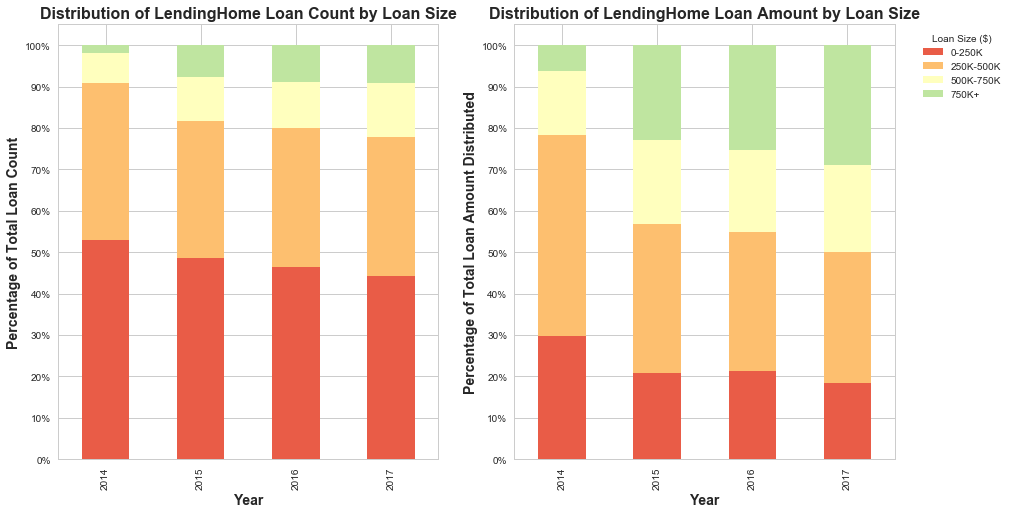

In [15]:
plot_loan_sizes('LendingHome', lender_regex="ILIKE '%%lendinghome%%'")

loan_size,year,0-250K_cnt,250K-500K_cnt,500K-750K_cnt,750K+_cnt,0-250K_sum,250K-500K_sum,500K-750K_sum,750K+_sum
0,2014,35.230352,52.845528,9.756098,2.168022,19.073105,55.267298,16.646780,9.012816
1,2015,31.507592,51.138829,14.750542,2.603037,15.841254,52.599583,24.633664,6.925499
2,2016,23.276561,55.150041,17.883212,3.690187,11.023439,52.228087,27.155745,9.592729
3,2017,23.389458,53.111274,19.143485,4.355783,10.963929,49.395722,28.591068,11.049281


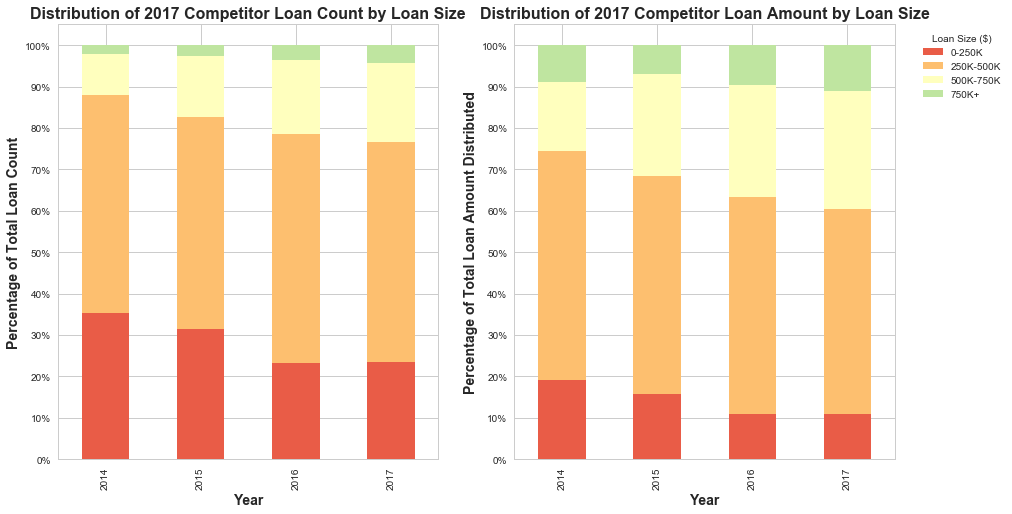

In [16]:
plot_loan_sizes('2017 Competitor', lender_regex="IN ('BENCHMARK MTG', 'ENVOY MTG LP', 'SUPREME LNDG')")

# Retention & Repeat Buyer Loans

LendingHome has a high percentage of loan transactions where the buyer has used LendingHome previously for a different loan - 56% in 2017. Unfortunately most of these repeat buyer loans tend to fall in the `small loan` category.<br/>
The average percentage of 'repeat buyer' transactions for lenders in the `2017 Competitors` cohort in 2017 was only 6%.

In [65]:
def get_repeat_customers(lender_name):
    """Find the transactions where the buyer has used LendingHome to take out a mortgage before."""
    query = """
    SELECT
      EXTRACT('year' FROM repeat_t.transaction_date) AS year,
      COUNT(1) AS repeat_buyer_loan_count
    FROM (
      SELECT
       DISTINCT t.id, t.transaction_date, t.loan_amount
      FROM mortgage_transactions t
      LEFT JOIN (SELECT
                 buyer, transaction_date
                 FROM mortgage_transactions
                 WHERE
                 loan_amount > 0
                 AND lender ILIKE '%%{lender_name}%%') prev_t ON t.buyer = prev_t.buyer
      WHERE
      loan_amount > 0
      AND t.transaction_date > prev_t.transaction_date
      AND lender ILIKE '%%{lender_name}%%'
    ) repeat_t
    GROUP BY 1
    ORDER BY 1
    """.format(lender_name=lender_name)
    df_repeat_percentage = pd.read_sql_query(query, engine)
    return df_repeat_percentage

,year,repeat_buyer_loan_count,total_loan_count,repeat_buyer_percentage
0,2014,100,153,65.359477
1,2015,283,527,53.700190
2,2016,219,467,46.895075
3,2017,289,519,55.684008


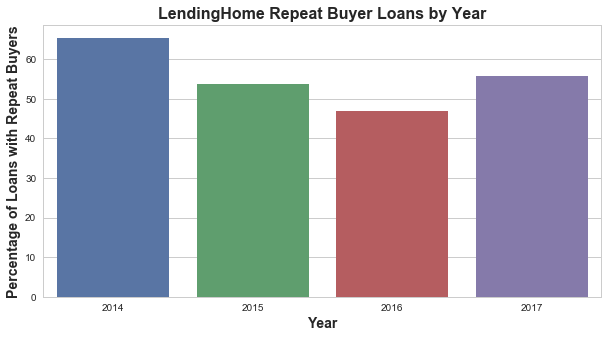

In [85]:
def plot_lh_repeat_buyers():
    lh_repeat_buyers = pd.merge(get_repeat_customers('lendinghome'), 
                                lh_annual_loan_data.reset_index(), on='year')
    lh_repeat_buyers['repeat_buyer_percentage'] = lh_repeat_buyers['repeat_buyer_loan_count'] * 100 / lh_repeat_buyers['total_loan_count']

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.yaxis.set_ticks(np.arange(0, 110, 10))
    p1 = sns.barplot(x="year", y="repeat_buyer_percentage", data=lh_repeat_buyers, ax=ax);
    p1.set_xlabel('Year')
    p1.set_ylabel('Percentage of Loans with Repeat Buyers')
    p1.set_title('LendingHome Repeat Buyer Loans by Year', fontweight='bold')
    return lh_repeat_buyers.loc[:, ['year', 'repeat_buyer_loan_count', 'total_loan_count', 'repeat_buyer_percentage']]

plot_lh_repeat_buyers()

In [78]:
def get_competitor_repeat_buyers():
    """Average the repeat buyer counts for the lenders in the 2017 competitor cohort"""
    competitors_2017 = ['BENCHMARK MTG', 'ENVOY MTG LP', 'SUPREME LNDG']
    df_total_lender_repeat_average = pd.DataFrame({
        'year': [2014, 2015, 2016, 2017],
        'repeat_buyer_loan_count': [0, 0, 0, 0]})
    df_total_lender_repeat_average = df_total_lender_repeat_average.set_index('year')
    for lender in competitors_2017:
        df_lender_repeat = get_repeat_customers(lender)
        print('Lender: ', lender)
        print(df_lender_repeat)
        df_total_lender_repeat_average = df_total_lender_repeat_average.add(df_lender_repeat.set_index('year'), fill_value=0)
    
    df_total_lender_repeat_average['repeat_buyer_loan_count']  = df_total_lender_repeat_average['repeat_buyer_loan_count'] / 3 # Average number of repeat transactions
    return df_total_lender_repeat_average

In [79]:
get_competitor_repeat_buyers()

Lender:  BENCHMARK MTG
   year  repeat_buyer_loan_count
0  2015                       19
1  2016                      107
2  2017                       38
Lender:  ENVOY MTG LP
   year  repeat_buyer_loan_count
0  2014                        2
1  2015                        9
2  2016                       58
3  2017                       32
Lender:  SUPREME LNDG
   year  repeat_buyer_loan_count
0  2014                        1
1  2015                       20
2  2016                       73
3  2017                       85


,repeat_buyer_loan_count
year,
2014,1.000000
2015,16.000000
2016,79.333333
2017,51.666667


Percentage of repeat buyer loans from 2017 Better Competitors Cohort = (Average # of repeat buyer loans in 2017 / Average # of Total Loans) = (51 / 910) = 6%

Look at the distribution of loan sizes for loans from repeat buyers

,count
loan_size,
0-250K,296
250K-500K,298
500K-750K,81
750K+,60


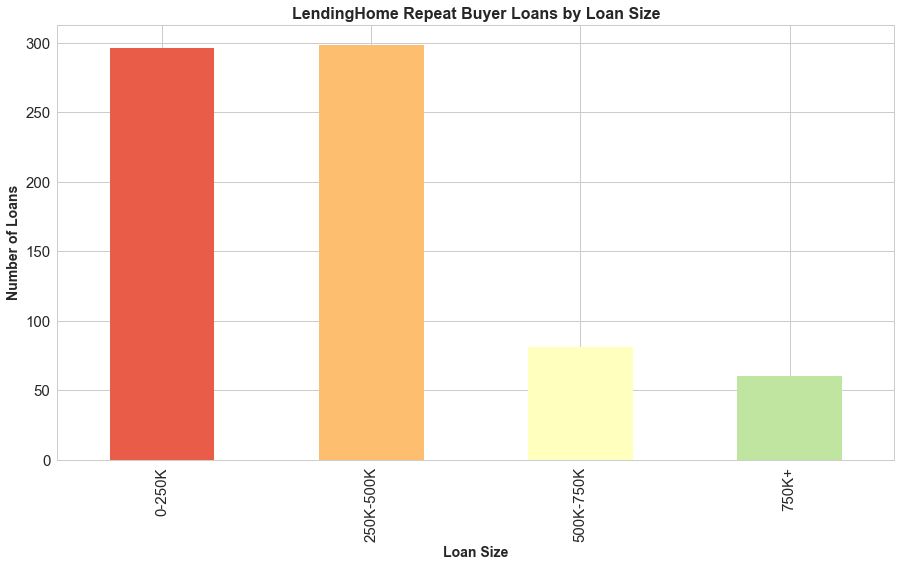

In [97]:
def plot_lh_repeat_loan_sizes():
    query = """
    SELECT
      CASE
       WHEN loan_amount BETWEEN 0 AND 249999
       THEN '0-250K'
       WHEN loan_amount BETWEEN 250000 AND 499999
       THEN '250K-500K'
       WHEN loan_amount BETWEEN 500000 AND 749999
       THEN '500K-750K'
       ELSE '750K+'
      END AS loan_size,
      COUNT(1)
    FROM (
      SELECT
       DISTINCT t.id, t.transaction_amount, t.transaction_date, t.loan_amount
      FROM mortgage_transactions t
      LEFT JOIN (SELECT
                 buyer, transaction_date
                 FROM mortgage_transactions
                 WHERE transaction_amount > 0
                 AND lender ILIKE '%%lendinghome%%') prev_t ON t.buyer = prev_t.buyer
      WHERE
      t.transaction_date > prev_t.transaction_date
      AND lender ILIKE '%%lendinghome%%'
    ) repeat_t
    GROUP BY 1
    ORDER BY 1
    """
    df_repeat_loan_size = pd.read_sql_query(query, engine)
    df_repeat_loan_size = df_repeat_loan_size.set_index('loan_size')
    colors = sns.color_palette("Spectral", 5)
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    p1 = df_repeat_loan_size.plot(ax=ax, kind='bar', figsize=(15, 8), color=colors)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel('Loan Size')
    ax.legend().set_visible(False)
    ax.set_ylabel('Number of Loans')
    ax.set_title('LendingHome Repeat Buyer Loans by Loan Size', fontweight='bold')
    return df_repeat_loan_size
    
plot_lh_repeat_loan_sizes()

## Recommendations

- As demonstrated by the lenders in the `2017 Better Competitors` cohort, there is room to grow by acquiring more medium and large sized loans
- Expand outside of LendingHome’s current roster of loan buyers to acquire more repeating buyers and reach new customers in need of larger loans
- Potential to increase number of refinance loans. There are double the number of refinance loan compared to regular loan transactions conducted across all mortgages